## 1. Load Data 

In [1]:
from datetime import date, timedelta
import datetime
import pandas as pd
import numpy as np
from tqdm import tqdm, tnrange

from sklearn.metrics import mean_squared_error
import lightgbm as lgb

import mlflow
import mlflow.sklearn

from config import (
    RAW_DATA_DIR,
    FEATURE_DIR,
    LAG_DICT,
    SLIDING_DICT
)

In [2]:
# load data
df_train = pd.read_csv(
    RAW_DATA_DIR+'train.csv', usecols=[1, 2, 3, 4, 5],
    dtype={'onpromotion': bool},
    converters={'unit_sales': lambda u: np.log1p(
        float(u)) if float(u) > 0 else 0},
    parse_dates=["date"],
    skiprows=range(1, 66458909)  # 2016-01-01
)

df_test = pd.read_csv(
    RAW_DATA_DIR+'test.csv', usecols=[0, 1, 2, 3, 4],
    dtype={'onpromotion': bool},
    parse_dates=["date"]  # , date_parser=parser
).set_index(
    ['store_nbr', 'item_nbr', 'date']
)

items = pd.read_csv(
    RAW_DATA_DIR+'items.csv',
).set_index("item_nbr")


### Test Period

2017-08-16 to 2017-08-31

In [3]:
test_start = date(2017, 8, 16)
test_end = date(2017,8, 31)

In [4]:

valid_start = test_start - timedelta(16)
while(1):
    if valid_start.weekday() == test_start.weekday():
        break
    valid_start = valid_start-timedelta(days=1)
valid_end = valid_start + timedelta(15)
print('valid starts from {} to {}'.format(valid_start, valid_end))

valid starts from 2017-07-26 to 2017-08-10


### Valid Period

Considering the more nearer peiods of sales data may have more in common, it would be better to find the nearest period as valid period.

Based on the analysis before, we assume the sales data is periodically with the frequency of 7 days, so we want to keep that feature same
in the train, valid and test period.

So finally, we choose valid period:

2017-07-26 to 2017-08-10


In [5]:
valid_start = date(2017, 7, 26)
valid_end = date(2017, 8, 10)

### Filter Period

#### Earthquake happended on April 16, 2016. It may affect for the next several weeks.

In [6]:
filter_date = date(2016,4,16) + timedelta(7*4)
lag_max = 140
train_start=  filter_date+timedelta(days=lag_max)

while(1):
    train_start = train_start + timedelta(1)
    if train_start.weekday() == valid_start.weekday():
        break
print('train datasets starts from {}'.format(train_start))

train datasets starts from 2016-10-05


In [7]:
y_start = valid_start - timedelta(21)
y_end = y_start + timedelta(15)

### Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.


In [8]:
df_train = df_train[df_train['date']>=filter_date]

/home/y/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


#### Label

In [9]:
# label
df_train = df_train.set_index(["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(level=-1).fillna(0)
df_train.columns = df_train.columns.get_level_values(1)

#### Filling missing date

In [10]:
date_list = df_train.columns
obj_list = pd.date_range(filter_date, test_start-timedelta(1))
diff_list = list(set(obj_list) - set(date_list)) 
for i in diff_list:
    print(i)
    df_train[i] = 0

2016-12-25 00:00:00


#### Generate train, valid and test sets

#### Train

In [11]:
X_train = df_train[pd.date_range(train_start, y_start - timedelta(1))].values
y_train = df_train[pd.date_range(y_start, y_end)].values

In [12]:
input_length = X_train.shape[1]

In [13]:
X_valid = df_train[pd.date_range(valid_start - timedelta(input_length), valid_start-timedelta(1))].values
y_valid = df_train[pd.date_range(valid_start, valid_end)].values 

## Training

In [5]:
import pandas as pd
import numpy as np

from config import (
    RAW_DATA_DIR,
    FEATURE_DIR
)

from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam

In [22]:
def wavenet_enhance_model(input_length, output_length):
    # convolutional operation parameters
    n_filters = 32 # 32 
    filter_width = 2
    dilation_rates = [2**i for i in range(8)] * 2 

    # define an input history series and pass it through a stack of dilated causal convolution blocks. 
    history_seq = Input(shape=(input_length, 1))
    x = history_seq

    skips = []
    for dilation_rate in dilation_rates:

        # preprocessing - equivalent to time-distributed dense
        x = Conv1D(16, 1, padding='same', activation='relu')(x) 

        # filter convolution
        x_f = Conv1D(filters=n_filters,
                     kernel_size=filter_width, 
                     padding='causal',
                     dilation_rate=dilation_rate)(x)

        # gating convolution
        x_g = Conv1D(filters=n_filters,
                     kernel_size=filter_width, 
                     padding='causal',
                     dilation_rate=dilation_rate)(x)

        # multiply filter and gating branches
        z = Multiply()([Activation('tanh')(x_f),
                        Activation('sigmoid')(x_g)])

        # postprocessing - equivalent to time-distributed dense
        z = Conv1D(output_length, 1, padding='same', activation='relu')(z)

        # residual connection
        x = Add()([x, z])    

        # collect skip connections
        skips.append(z)

    # add all skip connection outputs 
    out = Activation('relu')(Add()(skips))

    # final time-distributed dense layers 
    out = Conv1D(128, 1, padding='same')(out)
    out = Activation('relu')(out)
    out = Dropout(.2)(out)
    out = Conv1D(1, 1, padding='same')(out)

    # extract the last 60 time steps as the training target
    def slice(x, seq_length):
        return x[:,-seq_length:,:]

    pred_seq_train = Lambda(slice, arguments={'seq_length':output_length})(out)

    model = Model(history_seq, pred_seq_train)
    model.compile(Adam(), loss='mean_absolute_error')
    return model

In [23]:
model = wavenet_enhance_model(137, 16)
model.summary()

ValueError: Input 0 is incompatible with layer conv1d_261: expected ndim=3, found ndim=2

In [21]:
from sklearn.preprocessing import StandardScaler

In [23]:
X_train.shape

(171422, 273)

In [26]:
x = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

In [27]:
x.shape

(171422, 273, 1)

In [28]:
y.shape

(171422, 16, 1)

In [31]:
y_valid

x_v = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
y_v = np.reshape(y_valid, (y_valid.shape[0], y_valid.shape[1], 1))

In [ ]:
batch_size = 2**10
epochs = 10
model.compile(Adam(), loss='mean_squared_error')
history = model.fit(x,
                    y,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data = (x_v, y_v))


Train on 171422 samples, validate on 171422 samples
Epoch 1/10
 57344/171422 [=========>....................] - ETA: 12:05 - loss: 0.6360

It's typically a good idea to look at the convergence curve of train/validation loss.

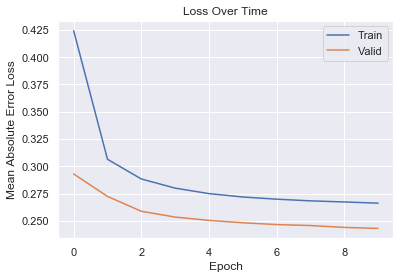

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])